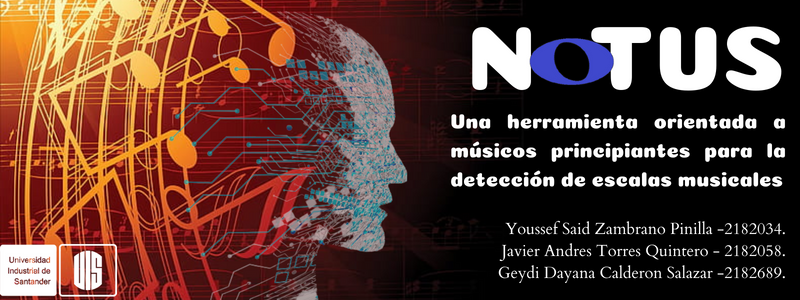

# Librerías

In [ ]:
import os
import tensorflow as tf
import librosa
import librosa.display
import IPython.display as ipd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Montar drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/notus/'
os.chdir(path)
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1d2oijaBkZNIicmLnat2O4wWpNgrN3TGl/notus


# Dataset


In [ ]:
c = tf.data.Dataset.list_files('/content/drive/MyDrive/notus/train/c/*.wav')
b = tf.data.Dataset.list_files('/content/drive/MyDrive/notus/train/b/*.wav')
tc = tf.data.Dataset.list_files('/content/drive/MyDrive/notus/test/tc/*.wav')
tb = tf.data.Dataset.list_files('/content/drive/MyDrive/notus/test/tb/*.wav')

In [ ]:
cs = tf.data.Dataset.zip((c, tf.data.Dataset.from_tensor_slices(tf.ones(len(c)))))
bs = tf.data.Dataset.zip((b, tf.data.Dataset.from_tensor_slices(tf.zeros(len(b)))))
tcs = tf.data.Dataset.zip((tc, tf.data.Dataset.from_tensor_slices(tf.ones(len(tc)))))
tbs = tf.data.Dataset.zip((tb, tf.data.Dataset.from_tensor_slices(tf.zeros(len(tb)))))


In [ ]:
data = cs.concatenate(bs)
tst = tcs.concatenate(tbs)

# Tensorflow para el procesamiento del audio


### Audio como onda

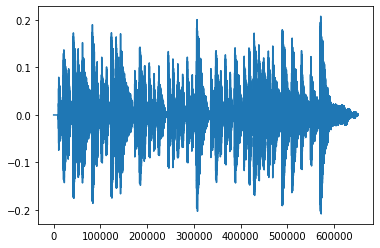

In [ ]:
file = tf.io.read_file('/content/drive/MyDrive/notus/train/c/1_c1.wav')
wav, sr = tf.audio.decode_wav(file, desired_channels=1)
wav = tf.squeeze(wav, axis=-1)
plt.plot(wav)
plt.show()

In [ ]:
ipd.Audio('/content/drive/MyDrive/notus/train/c/1_c1.wav')

## Funcion de procesamiento de onda a espectrograma


In [ ]:
def spectro(filepath, label): 
    file = tf.io.read_file(filepath)
    wav, sr = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    wav = wav[:48000]
    padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([padding, wav],0)
    spec = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spec = tf.abs(spec)
    spec = tf.expand_dims(spec, axis=2)

    return spec, label

### Aplicación de la función y ploteo de espectrograma

In [ ]:
filepath, label = cs.shuffle(buffer_size=10000).as_numpy_iterator().next()
spec, label = spectro(filepath, label)
spec.shape

TensorShape([1741, 257, 1])

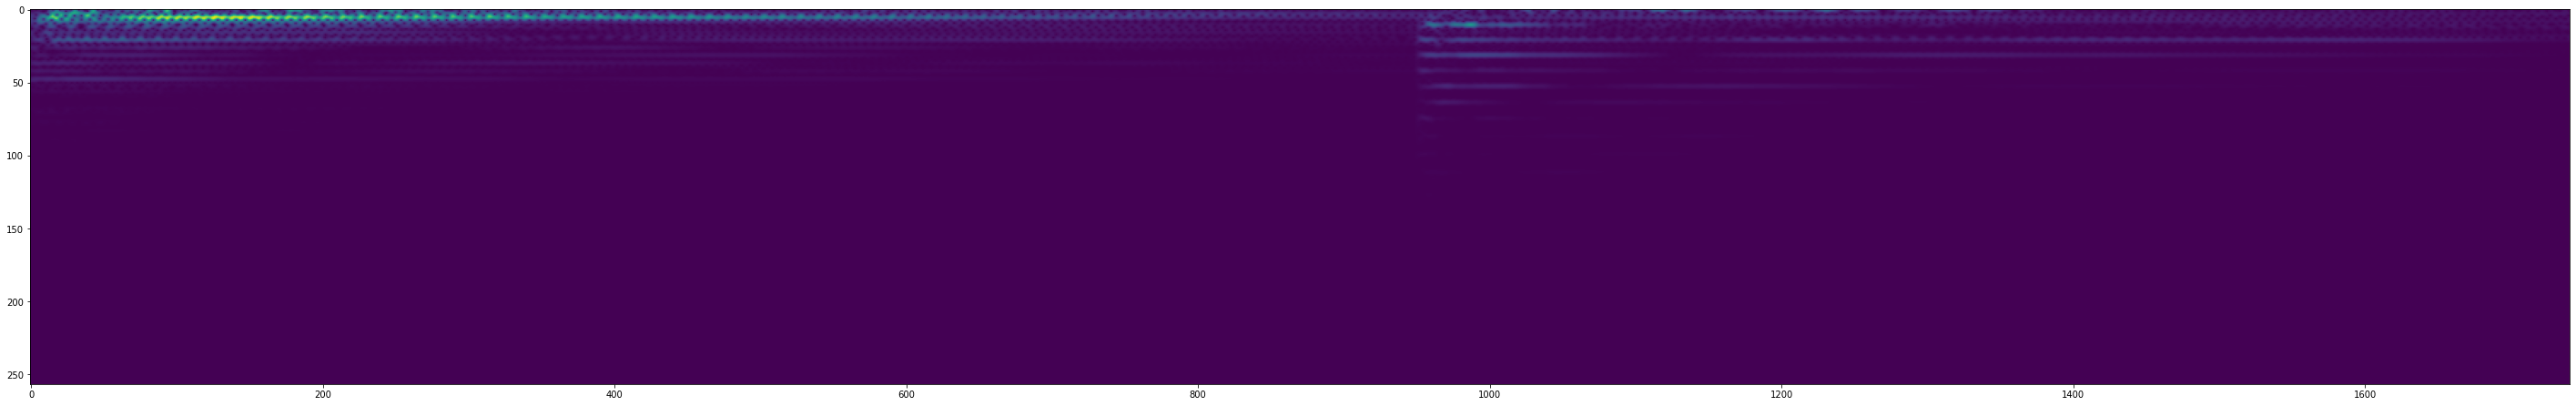

In [ ]:
plt.figure(figsize=(50,70))
plt.imshow(tf.transpose(spec)[0])
plt.show()

In [ ]:
filepath, label = bs.shuffle(buffer_size=10000).as_numpy_iterator().next()
specs, label = spectro(filepath, label)
specs.shape

TensorShape([1741, 257, 1])

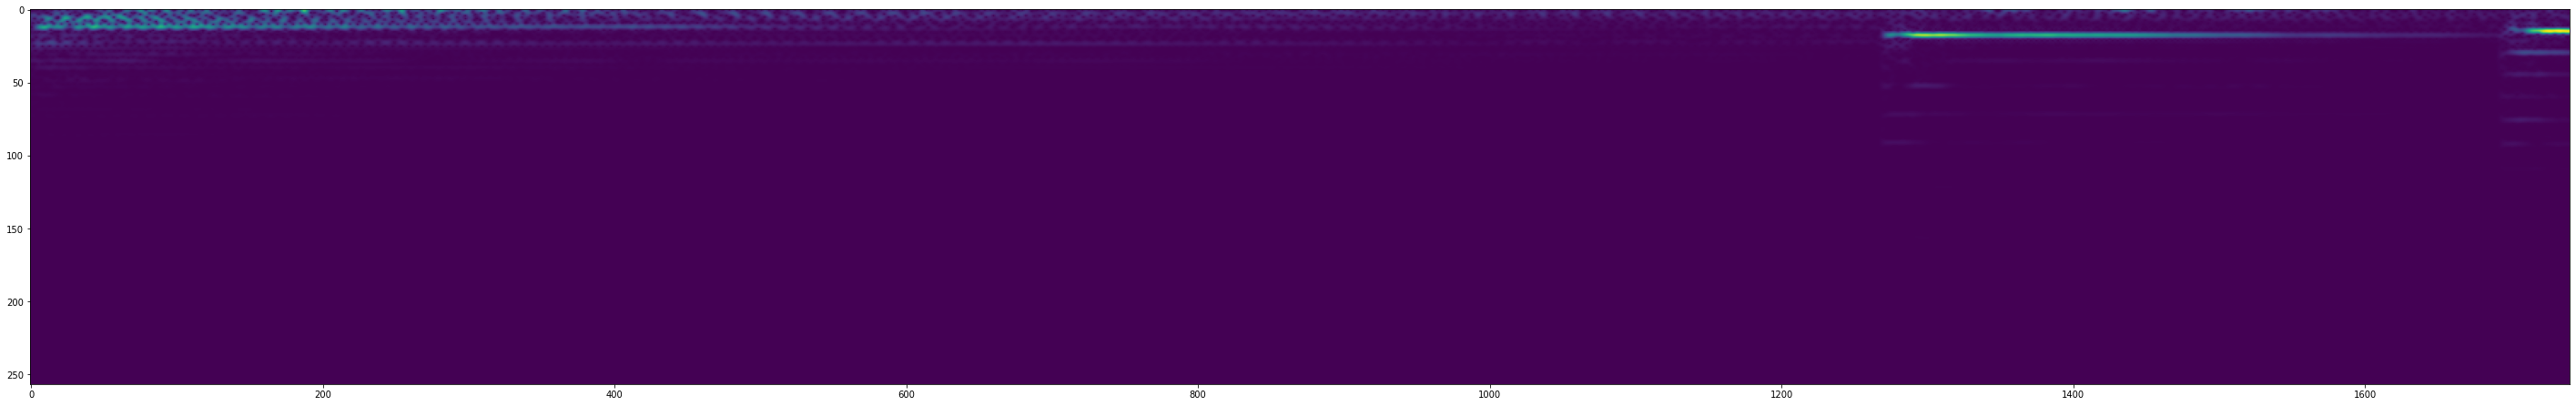

In [ ]:
plt.figure(figsize=(50,70))
plt.imshow(tf.transpose(specs)[0])
plt.show()

### Mapeo de los datos y creacion del dataset

In [ ]:
data = data.map(spectro)


In [ ]:
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [ ]:
data = data.batch(10)


In [ ]:
data = data.prefetch(8)

### Particion de los datos de entrenamiento y testeo

In [ ]:
train = data.take(4)

In [ ]:
test = data.skip(4).take(2)

In [ ]:
muestras, labels = train.as_numpy_iterator().next()

In [ ]:
muestras.shape

(10, 1741, 257, 1)

# Modelo

## Creación del modelo

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1741, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### Compilado entrenamiento y testeo

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1739, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1737, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 7031376)           0         
                                                                 
 dense (Dense)               (None, 128)               900016256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 900,018,865
Trainable params: 900,018,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

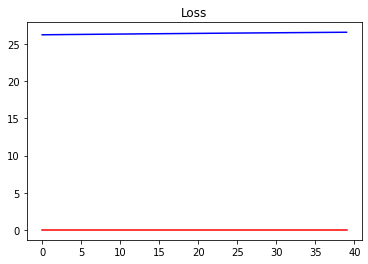

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

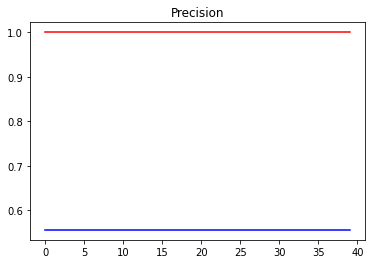

In [ ]:
plt.title('Precision')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

In [ ]:
X_test,  y_test_ohe = test.as_numpy_iterator().next()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_ohe, verbose=False)

print( 'Test accuracy:', test_acc, " test_loss: ", test_loss)

Test accuracy: 0.5555555820465088  test_loss:  26.5841064453125


In [ ]:
comp = model.predict(X_test)

In [ ]:
comp = [1 if prediction > 0.5 else 0 for prediction in comp]

In [ ]:
comp

[1, 1, 1, 1, 1, 1, 1, 1, 1]

# Usando librosa

## Audio como onda

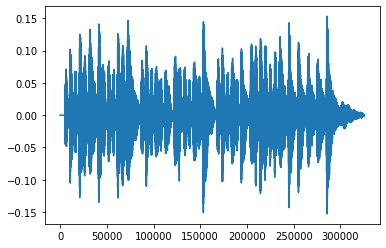

In [ ]:
wav, sr = librosa.load('/content/drive/MyDrive/notus/train/c/1_c1.wav')
plt.plot(wav)
plt.show()

## Audio como espectrograma

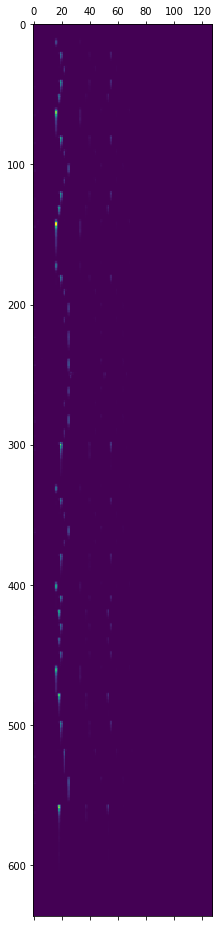

In [ ]:
spectr = librosa.feature.melspectrogram(wav)
plt.matshow(spectr.T)
plt.show()

## Funcion de padding

In [ ]:
def func_padding(wav, pad_size=3000):
    if wav.shape[0] > pad_size:
        return wav[0: pad_size]
    else:
        return np.hstack((wav, np.zeros(pad_size - wav.shape[0])))

## Funcion de procesamiento de datos

In [ ]:
def pros(path= '/content/drive/MyDrive/not/train/', pd_s=700):
    X = []
    y = []
    for file in os.listdir(path):
        st = file.split('_')
        ind = st[0]
        if (ind is '0') or (ind is '1'):
          wav, sr = librosa.load(path+ file)
          D = librosa.feature.melspectrogram(wav)
          padd = func_padding(D.reshape(D.shape[0]*D.shape[1]), pd_s)
          X.append(padd)        
          y.append(ind)
    return np.vstack(X), np.array(y)

## Dataset

In [ ]:
X, y = pros(path = '/content/drive/MyDrive/not/train/')
print( 'X:', X.shape)
print( 'y:', y.shape)

X: (60, 700)
y: (60,)


## Particion de entrenamiento y testeo 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_train[0].shape)

(42, 700) (42,)
(700,)


In [ ]:
y_train_k = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_k = tf.keras.utils.to_categorical(y_test, num_classes=2)
print(y_train_k.shape, y_test_k.shape)

(42, 2) (18, 2)


## Modelo

In [ ]:
model = Sequential()
model.add(Flatten(input_shape= X_train[0].shape))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [ ]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 700)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               179456    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 2)                 258       
                                                                 
Total params: 212,610
Trainable params: 212,610
Non-trainable params: 0
_________________________________________________________________


### Compilacion entrenamiento y testeo

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train_k,epochs=15, batch_size=100, validation_data=(X_test, y_test_k))

Epoch 1/15
1/1 [==============================] - 1s 504ms/step - loss: 0.6937 - accuracy: 0.6905 - val_loss: 1.0150 - val_accuracy: 0.7222
Epoch 2/15
1/1 [==============================] - 0s 26ms/step - loss: 0.5990 - accuracy: 0.7619 - val_loss: 1.0337 - val_accuracy: 0.7222
Epoch 3/15
1/1 [==============================] - 0s 26ms/step - loss: 0.4965 - accuracy: 0.7619 - val_loss: 0.9585 - val_accuracy: 0.6667
Epoch 4/15
1/1 [==============================] - 0s 26ms/step - loss: 0.3940 - accuracy: 0.7857 - val_loss: 0.9677 - val_accuracy: 0.4444
Epoch 5/15
1/1 [==============================] - 0s 27ms/step - loss: 0.3719 - accuracy: 0.8333 - val_loss: 1.0632 - val_accuracy: 0.5000
Epoch 6/15
1/1 [==============================] - 0s 26ms/step - loss: 0.3655 - accuracy: 0.8571 - val_loss: 1.1927 - val_accuracy: 0.4444
Epoch 7/15
1/1 [==============================] - 0s 26ms/step - loss: 0.3280 - accuracy: 0.8333 - val_loss: 1.3513 - val_accuracy: 0.5000
Epoch 8/15
1/1 [==========

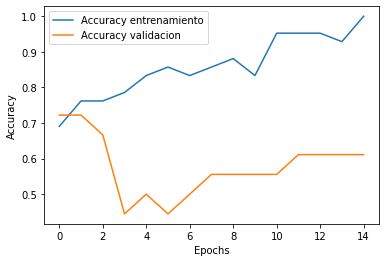

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validacion')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

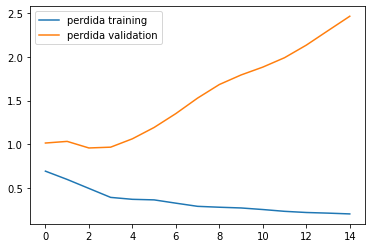

In [ ]:
plt.plot(history.history['loss'], label='perdida training')
plt.plot(history.history['val_loss'], label='perdida validation')
plt.legend()

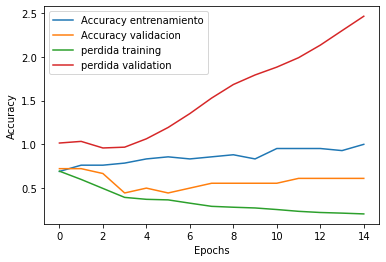

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy validacion')
plt.plot(history.history['loss'], label='perdida training')
plt.plot(history.history['val_loss'], label='perdida validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_k, verbose=False)

print( 'Test accuracy:', test_acc, " test_loss: ", test_loss)

Test accuracy: 0.5  test_loss:  2.57218861579895
